### Using Bitcoin's Historical Data to Predict Investment Return

In this analysis, we attempt to examine Bitcoin's historical data and determine if such data can be used to predict return on future Bitcoin investments.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

### Data Collection and Labeling

In [2]:
# Focus on Bitcoin Here

coin_df = pd.read_csv('Data/coin_Bitcoin.csv')

coin_df.index = pd.to_datetime(coin_df['Date']).dt.date
coin_df.index = pd.DatetimeIndex(coin_df.index)

# Not useful
coin_df.drop('Date', axis=1, inplace=True)
coin_df.drop('SNo', axis=1, inplace=True)
coin_df.drop('Symbol', axis=1, inplace=True)
coin_df.drop('Name', axis=1, inplace=True)

coin_df.head()

,High,Low,Open,Close,Volume,Marketcap
Date,,,,,,
2013-04-29,147.488007,134.000000,134.444000,144.539993,0.0,1.603769e+09
2013-04-30,146.929993,134.050003,144.000000,139.000000,0.0,1.542813e+09
2013-05-01,139.889999,107.720001,139.000000,116.989998,0.0,1.298955e+09
2013-05-02,125.599998,92.281898,116.379997,105.209999,0.0,1.168517e+09
2013-05-03,108.127998,79.099998,106.250000,97.750000,0.0,1.085995e+09


In [3]:
# Add a classification column. The class of each data point is determined by the percent change in close price
# day by day
coin_df['Return'] = coin_df['Close'].pct_change()
# First row in df has NaN 'return' since there is no previous day
coin_df.drop(coin_df.index[0], inplace=True)
coin_df.head()

,High,Low,Open,Close,Volume,Marketcap,Return
Date,,,,,,,
2013-04-30,146.929993,134.050003,144.000000,139.000000,0.0,1.542813e+09,-0.038328
2013-05-01,139.889999,107.720001,139.000000,116.989998,0.0,1.298955e+09,-0.158345
2013-05-02,125.599998,92.281898,116.379997,105.209999,0.0,1.168517e+09,-0.100692
2013-05-03,108.127998,79.099998,106.250000,97.750000,0.0,1.085995e+09,-0.070906
2013-05-04,115.000000,92.500000,98.099998,112.500000,0.0,1.250317e+09,0.150895


### Data Visualization

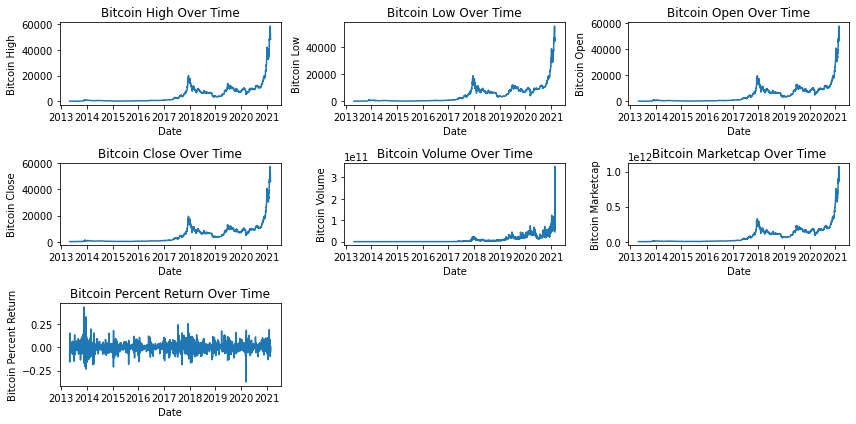

In [4]:
# A basic visualization of Date vs the coin_df columns
fig = plt.figure(figsize=(12, 6))

# High over time
high_axis = fig.add_subplot(3, 3, 1)
high_axis.plot(coin_df.index, coin_df['High'])
high_axis.set_title('Bitcoin High Over Time')
high_axis.set_xlabel('Date')
high_axis.set_ylabel('Bitcoin High')

# Low over time
low_axis = fig.add_subplot(3, 3, 2)
low_axis.plot(coin_df.index, coin_df['Low'])
low_axis.set_title('Bitcoin Low Over Time')
low_axis.set_xlabel('Date')
low_axis.set_ylabel('Bitcoin Low')

# Open over time
open_axis = fig.add_subplot(3, 3, 3)
open_axis.plot(coin_df.index, coin_df['Open'])
open_axis.set_title('Bitcoin Open Over Time')
open_axis.set_xlabel('Date')
open_axis.set_ylabel('Bitcoin Open')

# Close over time
close_axis = fig.add_subplot(3, 3, 4)
close_axis.plot(coin_df.index, coin_df['Close'])
close_axis.set_title('Bitcoin Close Over Time')
close_axis.set_xlabel('Date')
close_axis.set_ylabel('Bitcoin Close')

# Volume over time
volume_axis = fig.add_subplot(3, 3, 5)
volume_axis.plot(coin_df.index, coin_df['Volume'])
volume_axis.set_title('Bitcoin Volume Over Time')
volume_axis.set_xlabel('Date')
volume_axis.set_ylabel('Bitcoin Volume')

# Marketcap over time
marketcap_axis = fig.add_subplot(3, 3, 6)
marketcap_axis.plot(coin_df.index, coin_df['Marketcap'])
marketcap_axis.set_title('Bitcoin Marketcap Over Time')
marketcap_axis.set_xlabel('Date')
marketcap_axis.set_ylabel('Bitcoin Marketcap')

# Return over time
return_axis = fig.add_subplot(3, 3, 7)
return_axis.plot(coin_df.index, coin_df['Return'])
return_axis.set_title('Bitcoin Percent Return Over Time')
return_axis.set_xlabel('Date')
return_axis.set_ylabel('Bitcoin Percent Return')

plt.tight_layout()
plt.show()

---

### Class Assignment

In [5]:
# Sentiment on return: 
# > .10 then very good 0 < < 0.10 then good converse for bad and very bad
def get_sentiment(return_val):
    if return_val >= 0.10:
        return 'very good'
    elif return_val > 0 and return_val < 0.10:
        return 'good'
    elif return_val <= 0 and return_val > -0.10:
        return 'bad'
    elif return_val <= -0.10:
        return 'very bad'
    else:
        print(return_val)
        return None
# Replace Return column with label
coin_df['Return'] = [get_sentiment(return_val) for return_val in coin_df['Return']]
coin_df.head()

,High,Low,Open,Close,Volume,Marketcap,Return
Date,,,,,,,
2013-04-30,146.929993,134.050003,144.000000,139.000000,0.0,1.542813e+09,bad
2013-05-01,139.889999,107.720001,139.000000,116.989998,0.0,1.298955e+09,very bad
2013-05-02,125.599998,92.281898,116.379997,105.209999,0.0,1.168517e+09,very bad
2013-05-03,108.127998,79.099998,106.250000,97.750000,0.0,1.085995e+09,bad
2013-05-04,115.000000,92.500000,98.099998,112.500000,0.0,1.250317e+09,very good


In [6]:
# We are faced with a new problem: Class Imbalance. This will be addressed in the next section
class_counts = {}
for class_ in coin_df['Return']:
    class_counts[class_] = class_counts.get(class_, 0) + 1
print(class_counts)

{'bad': 1260, 'very bad': 50, 'very good': 66, 'good': 1485}


---

### Model Evaluation/Parameter Tuning

In the next few code blocks, we deal with Class Imbalance issues, and evaluate multiple models with fine-tuned parameters.

In [7]:
# To decide on the best model, we should fine tune the parameters of the models in consideration to see
# the best performances of our models.

# Because Bitcoin prices can be very volatile with plenty of outliers,
# we use RobustScaler
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import GridSearchCV

X = coin_df[['Open', 'High', 'Low', 'Volume', 'Marketcap', 'Close']]
y = coin_df['Return']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

transformer = RobustScaler().fit(X_train)
X_train = transformer.transform(X_train)
X_test = transformer.transform(X_test)

### Class Imbalance

As we saw above, the number of "good" vs "bad" data points heavily outweigh the "very good" and "very bad" data points. In the next cell, we attempt to assign class weights to account for this disparity.

In [8]:
# We should now deal with the issue of class_weights
from sklearn.utils import class_weight
labels = np.unique(y_train)
class_weights = dict(zip(labels, class_weight.compute_class_weight('balanced', classes=labels, y=y_train)))
print(class_weights)

{'bad': 0.5693970420932878, 'good': 0.4798657718120805, 'very bad': 15.166666666666666, 'very good': 10.648936170212766}


### Logistic Regression Evaluation

In [9]:
# Logistic Regression Parameter Tuning
from sklearn.linear_model import LogisticRegression
param_grid = {  'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
                }

lr = LogisticRegression(max_iter=2000, class_weight=class_weights)
grid = GridSearchCV(lr, param_grid)
grid.fit(X_train, y_train)
# lr_pred = lr.predict(X_test)
# print('Logistic Reg Score: {:.2f}'.format(lr.score(X_test, y_test)))
print("Best grid score: {:.2f}".format(grid.best_score_))
print("Grid test score: {:.2f}".format(grid.score(X_test, y_test)))
print("Best grid parameters: {}".format(grid.best_params_))
lr_best_params = grid.best_params_

Best grid score: 0.87
Grid test score: 0.86
Best grid parameters: {'C': 1000}


### Decision Tree Evaluation

In [10]:
# Decision Tree Parameter Tuning
from sklearn.tree import DecisionTreeClassifier
n_components = list(range(1,X.shape[1]+1,1))
criterion = ['gini', 'entropy']
max_depth = [2,4,6,8,10,12]
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [2,4,6,8,10,12,14,16,18,20,25,30,40,50,70]
}
dt = DecisionTreeClassifier(class_weight=class_weights)
grid = GridSearchCV(dt, param_grid)
grid.fit(X_train, y_train)
print("Best grid score: {:.2f}".format(grid.best_score_))
print("Grid test score: {:.2f}".format(grid.score(X_test, y_test)))
print("Best grid parameters: {}".format(grid.best_params_))
dt_best_params = grid.best_params_

Best grid score: 0.66
Grid test score: 0.69
Best grid parameters: {'criterion': 'entropy', 'max_depth': 30}


### KNN Evaluation

In [11]:
# K-Nearest Neighbors Parameter Tuning
from sklearn.neighbors import KNeighborsClassifier
param_grid = {
    'n_neighbors': [3, 5, 11, 19],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}
knn = KNeighborsClassifier() # No class_weight param
grid = GridSearchCV(knn, param_grid)
grid.fit(X_train, y_train)
print("Best grid score: {:.2f}".format(grid.best_score_))
print("Grid test score: {:.2f}".format(grid.score(X_test, y_test)))
print("Best grid parameters: {}".format(grid.best_params_))
knn_best_params = grid.best_params_

Best grid score: 0.62
Grid test score: 0.66
Best grid parameters: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}


### SVC Evaluation

In [12]:
# SVC Parameter Tuning
from sklearn.svm import SVC
param_grid = {
    'C':[1,10,100,1000],
    'gamma':[1,0.1,0.001,0.0001],
    'kernel':['linear','rbf']
}
svc = SVC(class_weight=class_weights)
grid = GridSearchCV(svc, param_grid)
grid.fit(X_train, y_train)
print("Best grid score: {:.2f}".format(grid.best_score_))
print("Grid test score: {:.2f}".format(grid.score(X_test, y_test)))
print("Best grid parameters: {}".format(grid.best_params_))
svc_best_params = grid.best_params_

Best grid score: 0.87
Grid test score: 0.86
Best grid parameters: {'C': 1000, 'gamma': 1, 'kernel': 'linear'}


### Retraining with Best Parameters

In [13]:
# Let's retrain the models using the fine-tuned parameters found
# so we can examine the confusion matrix and scoring report and make a conclusion.
lr = LogisticRegression(max_iter=2000, C=lr_best_params['C'], class_weight=class_weights)
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)
print('Logistic Regression Score: {:.2f}'.format(lr.score(X_test, y_test)))

dt = DecisionTreeClassifier(criterion=dt_best_params['criterion'], max_depth=dt_best_params['max_depth'], class_weight=class_weights)
dt.fit(X_train, y_train)
dt_pred = dt.predict(X_test)
print('Decision Tree Score: {:.2f}'.format(dt.score(X_test, y_test)))

knn = KNeighborsClassifier(metric=knn_best_params['metric'], n_neighbors=knn_best_params['n_neighbors'], weights=knn_best_params['weights'])
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)
print('KNN Score: {:.2f}'.format(knn.score(X_test, y_test)))

svc = SVC(C=svc_best_params['C'], gamma=svc_best_params['gamma'], kernel=svc_best_params['kernel'], class_weight=class_weights)
svc.fit(X_train, y_train)
svc_pred = svc.predict(X_test)
print('SVC Score: {:.2f}'.format(svc.score(X_test, y_test)))

Logistic Regression Score: 0.86
Decision Tree Score: 0.69
KNN Score: 0.66
SVC Score: 0.86


---

### Score Reporting

Here, we take a closer look at the performance of our models, as raw accuracy is often not a great indicator.

### Confusion Matrices

In [14]:
from sklearn.metrics import confusion_matrix
labels = ["Bad", "Good", "Very Good", "Very Bad"]
print("Logistic Regression Confusion Matrix:")
print(pd.DataFrame(confusion_matrix(y_test, lr_pred), index=labels, columns=labels), '\n')
print("Decision Tree Classifier Confusion Matrix:")
print(pd.DataFrame(confusion_matrix(y_test, dt_pred), index=labels, columns=labels), '\n')
print("KNN Classifier Confusion Matrix:")
print(pd.DataFrame(confusion_matrix(y_test, knn_pred), index=labels, columns=labels), '\n')
print("SVC Classifier Confusion Matrix:")
print(pd.DataFrame(confusion_matrix(y_test, svc_pred), index=labels, columns=labels), '\n')

Logistic Regression Confusion Matrix:
           Bad  Good  Very Good  Very Bad
Bad        306    28         46         1
Good        23   395         14        10
Very Good    0     0         17         0
Very Bad     0     1          0        18 

Decision Tree Classifier Confusion Matrix:
           Bad  Good  Very Good  Very Bad
Bad        277   101          3         0
Good       120   307          3        12
Very Good    8     3          6         0
Very Bad     2    15          0         2 

KNN Classifier Confusion Matrix:
           Bad  Good  Very Good  Very Bad
Bad        235   146          0         0
Good       112   327          0         3
Very Good   10     3          4         0
Very Bad     4    13          0         2 

SVC Classifier Confusion Matrix:
           Bad  Good  Very Good  Very Bad
Bad        307    37         36         1
Good        30   398          9         5
Very Good    0     0         17         0
Very Bad     1     1          2        15 



### Classification Reports (f1-score, precision, accuracy, etc.)

In [15]:
from sklearn.metrics import classification_report
print("Logistic Regression Classification Report:")
print(classification_report(y_test, lr_pred), '\n')
print("Decision Tree Classifier Classification Report:")
print(classification_report(y_test, dt_pred), '\n')
print("KNN Classifier Classification Report:")
print(classification_report(y_test, knn_pred), '\n')
print("SVC Classifier Classification Report:")
print(classification_report(y_test, svc_pred), '\n')

Logistic Regression Classification Report:
              precision    recall  f1-score   support

         bad       0.93      0.80      0.86       381
        good       0.93      0.89      0.91       442
    very bad       0.22      1.00      0.36        17
   very good       0.62      0.95      0.75        19

    accuracy                           0.86       859
   macro avg       0.68      0.91      0.72       859
weighted avg       0.91      0.86      0.88       859
 

Decision Tree Classifier Classification Report:
              precision    recall  f1-score   support

         bad       0.68      0.73      0.70       381
        good       0.72      0.69      0.71       442
    very bad       0.50      0.35      0.41        17
   very good       0.14      0.11      0.12        19

    accuracy                           0.69       859
   macro avg       0.51      0.47      0.49       859
weighted avg       0.69      0.69      0.69       859
 

KNN Classifier Classification Repor

### Interpretation of Evaluation

The confusion matrices and the classification reports above give us more insight into the performance of the models. From lecture, "When the skew in the class distributions are severe, accuracy can become an unreliable measure of model performance". This is apparent here due to the disproportion between "bad" and "good" data points vs. "very bad" and "very good" data points.

Looking at the metrics for our **LogisticRegression** model, we see from the confusion matrix that its accuracy is not all due to the correct "good" and "bad" classifications. We see that it was able to classify "very good" and "very bad" data points accurately. However, when we examing the classification report, we see that the f1-score for "very bad" is not ideal. This is due to the fact that while we have the maximum recall, we have a low precision. This is a con of this model that needs to be considered.

We can safely eliminate the **DecisionTreeClassifier** and the **KNeighborsClassifier** from our candidate models as they are unable to have any success in predicting the two classes with the fewest data points. This is supported by their respective classification reports.

Finally, we have the **SVC Classifier**. This classifier's performance is up-to-par with our **LogisticRegression** classifier (which is the best model seen thus far). We see that while its success with "very bad" is not as good as its Logistic counterpart, we observe higher f1-scores. While the f1-scores for "very bad" and "very good" leave something to be desired, we can say that, overall, the SVC provides us with better metrics.

Thus, we will proceed with the SVC Classifier for feature selection. 

---

### Model-Based Feature Selection with SVC

### Metrics with All Features

In [16]:
from sklearn.feature_selection import SelectFromModel

labels = ["Bad", "Good", "Very Good", "Very Bad"]

svc = SVC(C=svc_best_params['C'],
          gamma=svc_best_params['gamma'],
          kernel=svc_best_params['kernel'],
          class_weight=class_weights)

select = SelectFromModel(svc, threshold='median')
select.fit(X_train, y_train)
X_train_fs = select.transform(X_train)

# With all features
svc.fit(X_train, y_train)
print('Score with all features: {:.3f}'.format(svc.score(X_test, y_test)))
svc_pred = svc.predict(X_test)
print(pd.DataFrame(confusion_matrix(y_test, svc_pred), index=labels, columns=labels), '\n')
print(classification_report(y_test, svc_pred))

Score with all features: 0.858
           Bad  Good  Very Good  Very Bad
Bad        307    37         36         1
Good        30   398          9         5
Very Good    0     0         17         0
Very Bad     1     1          2        15 

              precision    recall  f1-score   support

         bad       0.91      0.81      0.85       381
        good       0.91      0.90      0.91       442
    very bad       0.27      1.00      0.42        17
   very good       0.71      0.79      0.75        19

    accuracy                           0.86       859
   macro avg       0.70      0.87      0.73       859
weighted avg       0.89      0.86      0.87       859



### Metrics with Selected Features

In [17]:
# With selected features
svc.fit(X_train_fs, y_train)
X_test_fs = select.transform(X_test)
svc_pred = svc.predict(X_test_fs)

mask = select.get_support()
selected_features = []
for i in range(len(X.columns)):
    if mask[i]:
        selected_features += [X.columns[i]]

print(f'Selected Features: {selected_features}')
print('Score with selected features: {:.3f}'.format(svc.score(X_test_fs, y_test)))
print(pd.DataFrame(confusion_matrix(y_test, svc_pred), index=labels, columns=labels), '\n')
print(classification_report(y_test, svc_pred))

Selected Features: ['Open', 'High', 'Close']
Score with selected features: 0.796
           Bad  Good  Very Good  Very Bad
Bad        337     2         42         0
Good        93   314         28         7
Very Good    0     0         17         0
Very Bad     3     0          0        16 

              precision    recall  f1-score   support

         bad       0.78      0.88      0.83       381
        good       0.99      0.71      0.83       442
    very bad       0.20      1.00      0.33        17
   very good       0.70      0.84      0.76        19

    accuracy                           0.80       859
   macro avg       0.67      0.86      0.69       859
weighted avg       0.88      0.80      0.82       859



While we observed a drop in accuracy with the selected features, this is necessarily always a bad sign. We want to avoid overfitting, and too many features may contribute to this. While we did notice a slight drop in f1-scores, we believe that this is a consequence of our model not overfitting as much.

---

### Cross Fold Validation

In [18]:
# Now that we have fine-tuned our chose model, we can observe its performance with a cross-fold validation.
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline

# "Reset" our data
X = coin_df[['Open', 'High', 'Low', 'Volume', 'Marketcap', 'Close']]
y = coin_df['Return']

# Our best model
svc = SVC(C=svc_best_params['C'],
          gamma=svc_best_params['gamma'],
          kernel=svc_best_params['kernel'],
          class_weight=class_weights)

# Use a pipeline to include scaling and feature selection
clf = make_pipeline(RobustScaler(), SelectFromModel(svc), svc)
scores = cross_val_score(clf, X, y, cv=10)
print('Scores over 10 runs')
print(scores)

Scores over 10 runs
[0.6445993  0.82167832 0.6993007  0.88811189 0.8986014  0.96853147
 0.95804196 0.97202797 0.98601399 0.97902098]


### Further Insights

The results above provide some more interesting insights. We see that the data split used for training heavily influences the overall accuracy. These scores provide more insight into the dataset we have. What we can infer from the worst performances (\~60%) is that the test data is dense with "very good" and "very bad" data points. Similarly, we can assume, for the overly-high scores (\~97%), that the test data is heavily skewed towards "good" and "bad" due to a lack of "very bad" and "very good" data points.